### IT4342E PROJECT - Chessboard Size Measurement
- Trần Quang Hải - 20194755
- Nguyễn Ngọc Linh - 20194790
- Phan Xuân Tân - 20194833
- Nguyễn Lưu Hoàng Minh - 20194798

#### I. Import necessary libraries

In [1]:
import cv2 
import os
import numpy as np 
import matplotlib.pyplot as plt 

from collections import Counter, defaultdict
from scipy.spatial import distance_matrix
from scipy.signal import medfilt


%matplotlib inline 

#### II. Import list of images


For reading convenience, we demonstrate our solution on 4 noticeable images with poor quality and noises.
- `Data\Chessboard_00451_1.png`
- `Data\Chessboard_0481_0.png`
- `Data\Chessboard0631.png`
- `Data\Chessboard_0481_1.png`

In [2]:
im_path_prediodic_noise = 'Data\Chessboard_00451_1.png'
im_path_heavily_noised = 'Data\Chessboard_0481_0.png'
im_path_chessboard_missing_corner = 'Data\Chessboard0631.png'
im_path_low_contrast = 'Data\Chessboard_0481_1.png'

img_prediodic_noise = cv2.imread(im_path_prediodic_noise)
img_heavily_noised = cv2.imread(im_path_heavily_noised)
img_chessboard_missing_corner = cv2.imread(im_path_chessboard_missing_corner)
img_low_contrast = cv2.imread(im_path_low_contrast)

images = [img_prediodic_noise, img_heavily_noised, img_chessboard_missing_corner, img_low_contrast]

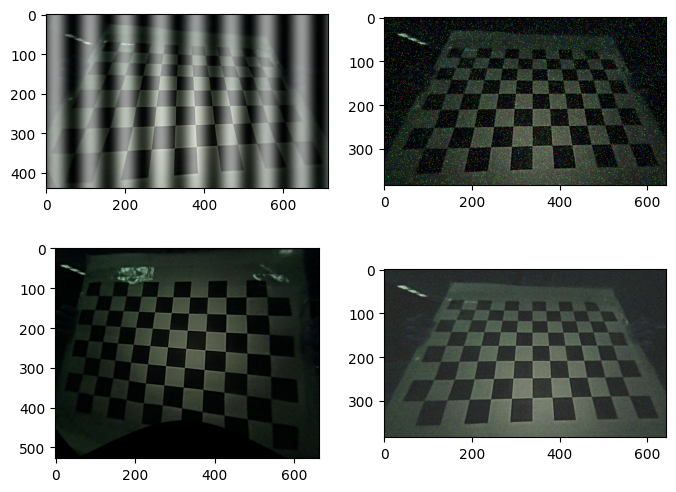

In [3]:
fig = plt.figure(figsize=(8, 6))
columns = 2
rows = 2
for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
plt.show()

#### III. Reduce noise and enhance images' quality

##### 1. Periodic noise filtering

In [4]:
from scipy.ndimage import median_filter

def unsharp(image, sigma=1, strength=0.7):
    # Gaussian filtering
    ksize = int(sigma * 5) | 1
    ksize = ksize if ksize > 1 else 3
    image_gf = cv2.GaussianBlur(image, (ksize, ksize), sigma)

    # Calculate the Laplacian
    kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    lap = cv2.filter2D(image_gf, -1, kernel)

    # Calculate the sharpened image
    sharp = image + strength * lap

    return sharp

Show magnitude spectrum of the image which has periodic noise

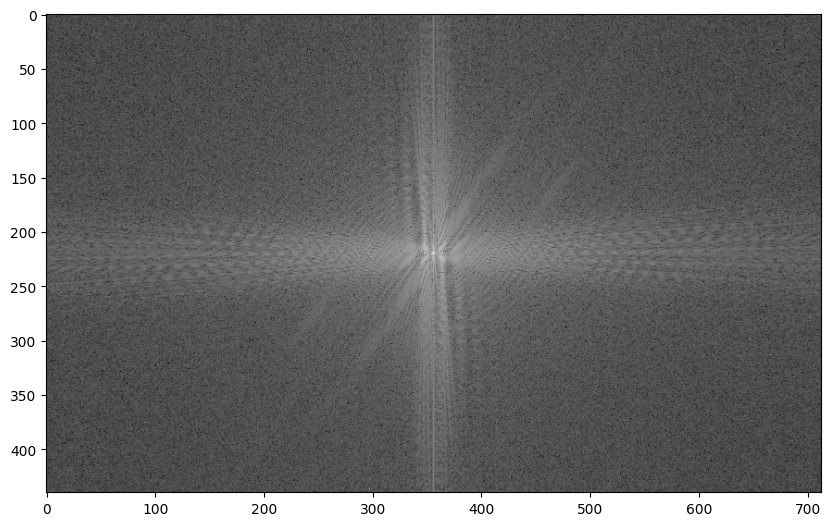

In [5]:
gray = cv2.cvtColor(img_prediodic_noise, cv2.COLOR_BGR2GRAY)
dft = cv2.dft(np.float32(gray),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
plt.figure(figsize=(10,10))
plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.show()

We want to find 2 brightest dot on the above picture because it is the representation of the sine noise in the original image

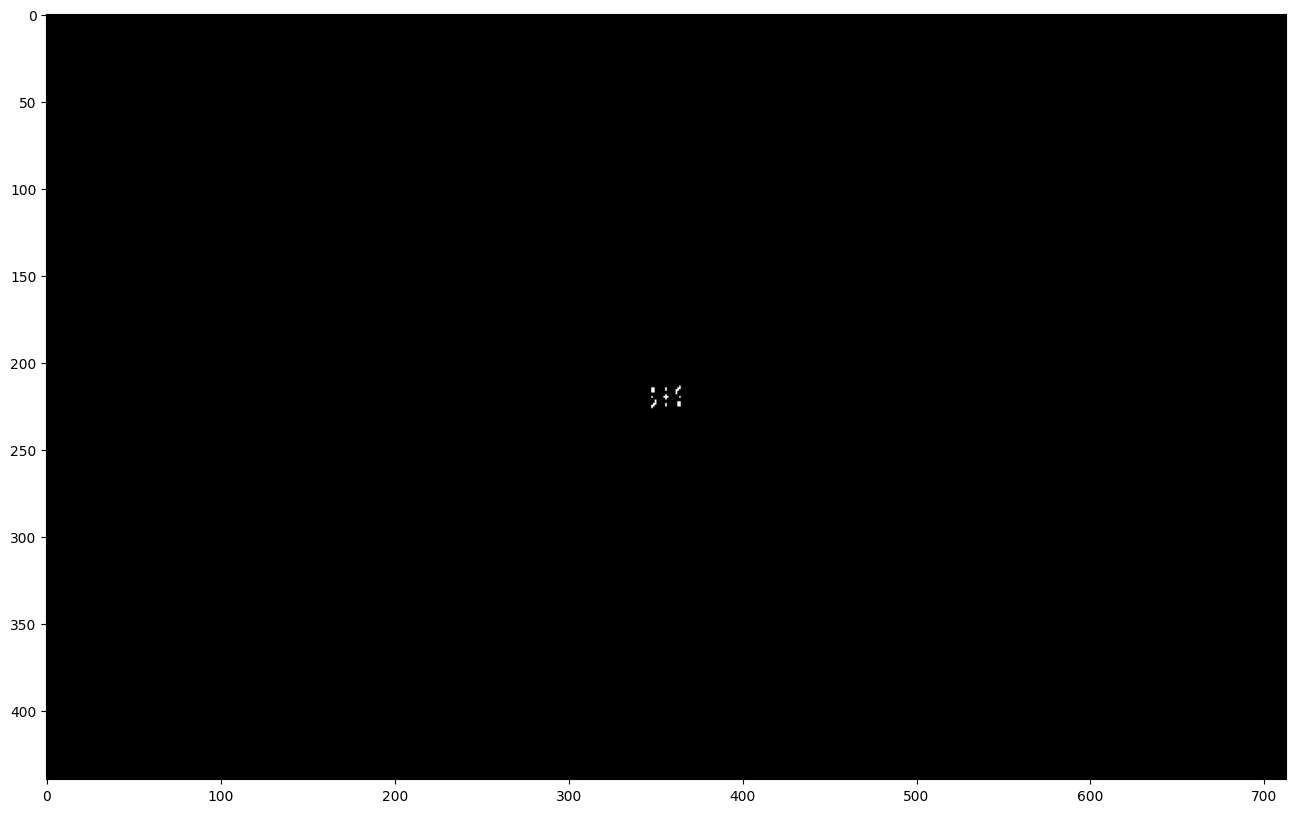

In [6]:
thresh = cv2.threshold(magnitude_spectrum, 255, 255, cv2.THRESH_BINARY)[1]
plt.figure(figsize=(16,16))
plt.imshow(thresh, cmap = 'gray')
plt.show()

We find contours in the above image. After that, we filter out smallest and brightest dot to apply high-pass filtering to eliminate sine noise

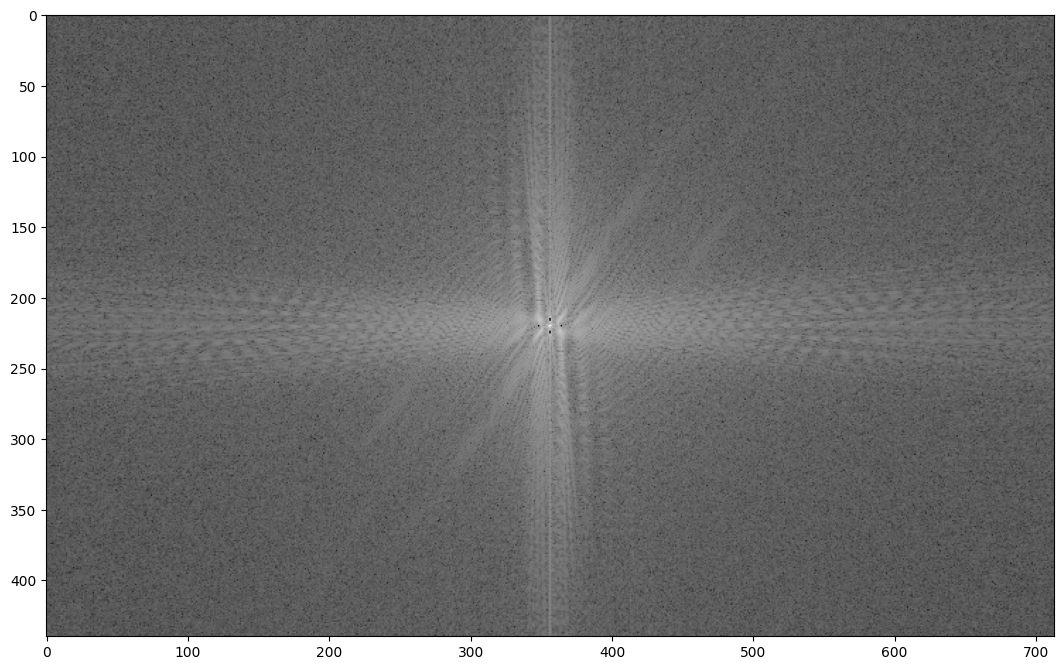

In [7]:
thresh = thresh.astype(np.uint8)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

for contour in contours:
    area = cv2.contourArea(contour)
    if area == 0: 
        cv2.drawContours(magnitude_spectrum, contour, -1, (0,0,0), -1)
        cv2.drawContours(dft_shift, contour, -1, (255,255,255), -1)
        
plt.figure(figsize=(13,13))
plt.imshow(magnitude_spectrum, cmap='gray')

The image with periodic noise removal

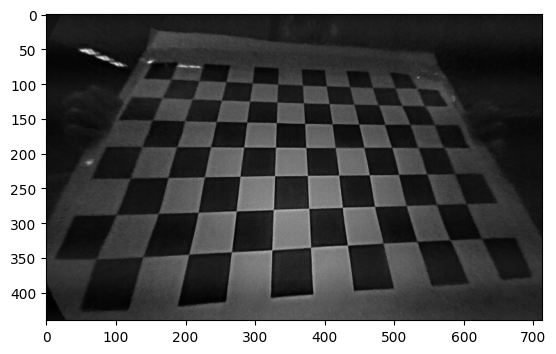

In [8]:
dft_ishift = np.fft.ifftshift(dft_shift)
idft = cv2.idft(dft_ishift)
img_sine_noise_filtered = cv2.magnitude(idft[:,:,0],idft[:,:,1])
img_sine_noise_filtered = cv2.normalize(img_sine_noise_filtered, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
plt.imshow(img_sine_noise_filtered, cmap='gray')
plt.show()

Rewrite above procedure into function `periodic_noise_removal`

In [9]:
def periodic_noise_removal(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    dft = cv2.dft(np.float32(gray),flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
    
    thresh = cv2.threshold(magnitude_spectrum, 255, 255, cv2.THRESH_BINARY)[1]
    thresh = thresh.astype(np.uint8)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        if area == 0: 
            cv2.drawContours(dft_shift, contour, -1, (0,0,0), -1)
            
    dft_ishift = np.fft.ifftshift(dft_shift)
    idft = cv2.idft(dft_ishift)
    img_sine_noise_filtered = cv2.magnitude(idft[:,:,0],idft[:,:,1])

    img_sine_noise_filtered = cv2.normalize(img_sine_noise_filtered, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return img_sine_noise_filtered

Enhance image quality

In [10]:
def enhance_image_quality(img):
    lookUpTable = np.empty((1,256), np.uint8)
    gamma = 0.8
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    denoise_image = cv2.medianBlur(img,5) 
    fft_image = periodic_noise_removal(denoise_image)
    bright_image = cv2.LUT(fft_image, lookUpTable)
    kernel = np.array([[-1,-1,-1], [-1, 9,-1], [-1,-1,-1]])
    sharp_img = cv2.filter2D(src=bright_image, ddepth=-1, kernel=kernel)
    return bright_image, fft_image, sharp_img
        

Images after enhanced

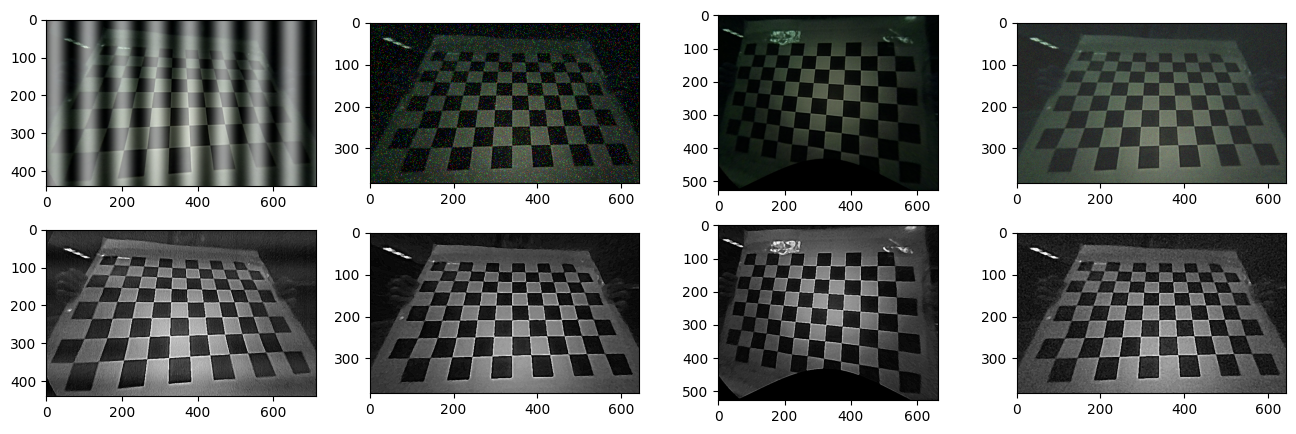

In [11]:
enhanced_images = []
fft_images = []
bright_images = []
for img in images:
    bright_image, fft_image, enhanced_img = enhance_image_quality(img)
    enhanced_images.append(enhanced_img)
    fft_images.append(fft_images)
    bright_images.append(bright_image)

total_images = images + enhanced_images
fig = plt.figure(figsize=(16, 5))
columns = 4
rows = 2
for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(total_images[i-1], cmap="gray")
plt.show()


In [12]:
def show_points(image, pts, show_label = False):
    print('Number of points: ', len(pts))
    plt.figure(figsize=(12,12))
    img_copy = np.copy(image)
    pts = pts.tolist()
    for index, p in enumerate(pts):
        y, x = p 
        cv2.circle(img_copy, (x, y), 3, (0, 0, 255), -1)
        if (show_label == True):
            cv2.putText(img_copy, str(index), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6,  (255, 0, 0), 1)

    plt.imshow(img_copy[...,[2,1,0]])
    plt.show()

Remove outer contour to keep only the keyboard at the middle of the image

In [13]:
def remove_outer_contour(thresh):
    contours, _ = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        max_contour = max(contours, key=cv2.contourArea)
        if cv2.contourArea(max_contour) > 4000:
            mask = np.zeros_like(thresh)
            cv2.drawContours(mask, [max_contour], -1, (1), -1)
            nthresh = np.zeros_like(thresh)
            nthresh.fill(255)
            thresh = nthresh * np.where(mask == 1, 0, 1) + thresh * mask

    contours, _ = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        if cv2.contourArea(c) < 200:
            cv2.drawContours(thresh, [c], -1, (255, 255, 255), -1)

    return thresh.astype(np.uint8)


Detect key points on the chessboard

In [14]:
class SquareResponseFilter:
    def __init__(self, size=8, half_smoothing_window_size=4):
        self.size = size
        self.half_smoothing_window_size = half_smoothing_window_size

    def _get_square_response(self, image, point):
        """Iterate through a square centered at keypoint and get a response."""
        assert len(image.shape) == 2, 'Image must be binarized.'
        k = self.size
        # top-left, bottom-right
        tl, br = point - k, point + k
        # top-right, bottom-left
        tr = np.array([point[0] - k, point[1] + k])
        bl = np.array([point[0] + k, point[1] - k])

        response = []
        for j in range(tl[1], tr[1]):
            response.append(image[tl[0], j])
        for i in range(tr[0], br[0]):
            response.append(image[i, tr[1]])
        for j in range(br[1], bl[1], -1):
            response.append(image[br[0], j])
        for i in range(bl[0], tl[0], -1):
            response.append(image[i, bl[1]])
        # return self._majority_vote_smoothing(response)
        return response

    @staticmethod
    def _count_segments(response):
        prev = response[0]
        cnt = 1
        for cur in response[1:]:
            if cur != prev:
                cnt += 1
            prev = cur
        return cnt

    def filter(self, binarized, corners):
        kept = []
        for corner in corners:
            try:
                response = self._get_square_response(binarized, corner)
            except IndexError:  # If a point to too close to the border
                continue
            if self._count_segments(response) in [4, 5]:
                kept.append(corner)
        return np.array(kept)

In [15]:
def detect_key_points(img): 
    gray = cv2.GaussianBlur(img, (3, 3), 0)
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,151,5)
    thresh = remove_outer_contour(thresh)

    corners = cv2.goodFeaturesToTrack(thresh, 500,0.01, 20)
    corners = np.intp(corners)
    points = np.array([[i.ravel()[1], i.ravel()[0]] for i in corners])
    square_response_filter = SquareResponseFilter()
    filter_points = square_response_filter.filter(thresh, points)
    show_points(np.stack((thresh, thresh, thresh), axis=-1), filter_points, show_label=True)
    return filter_points

Number of points:  79


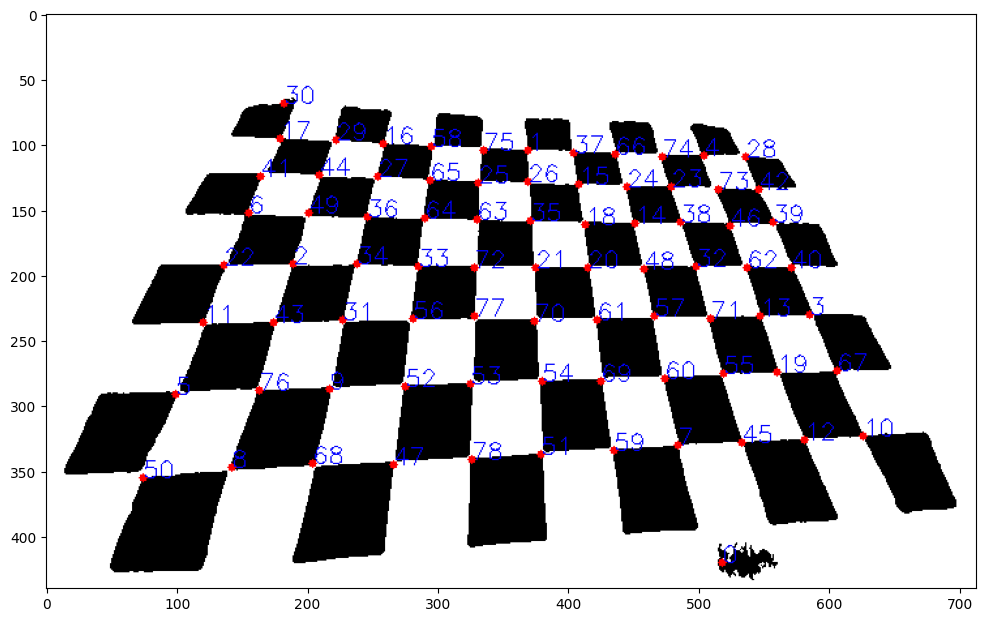

Number of points:  76


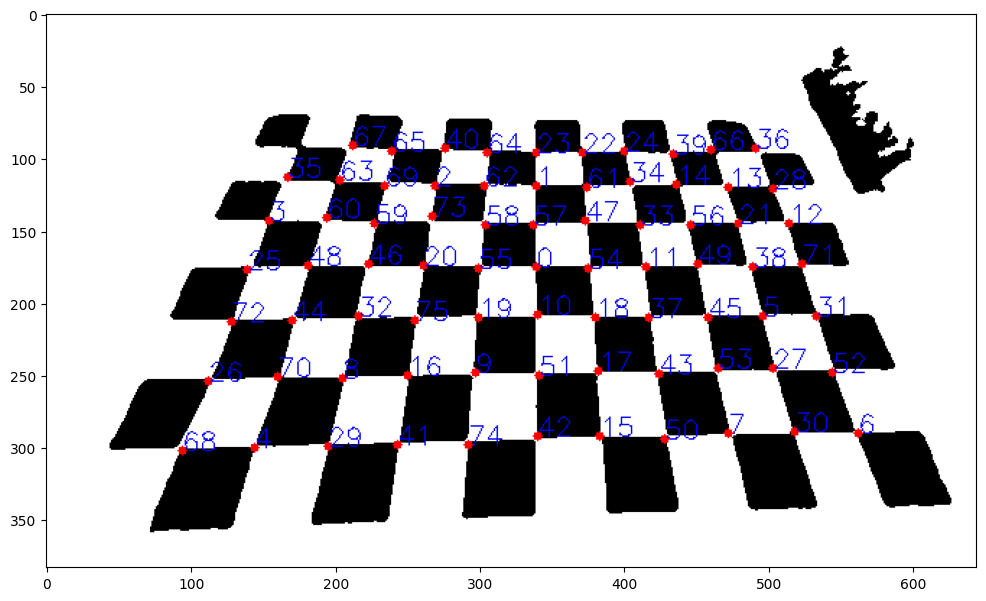

Number of points:  81


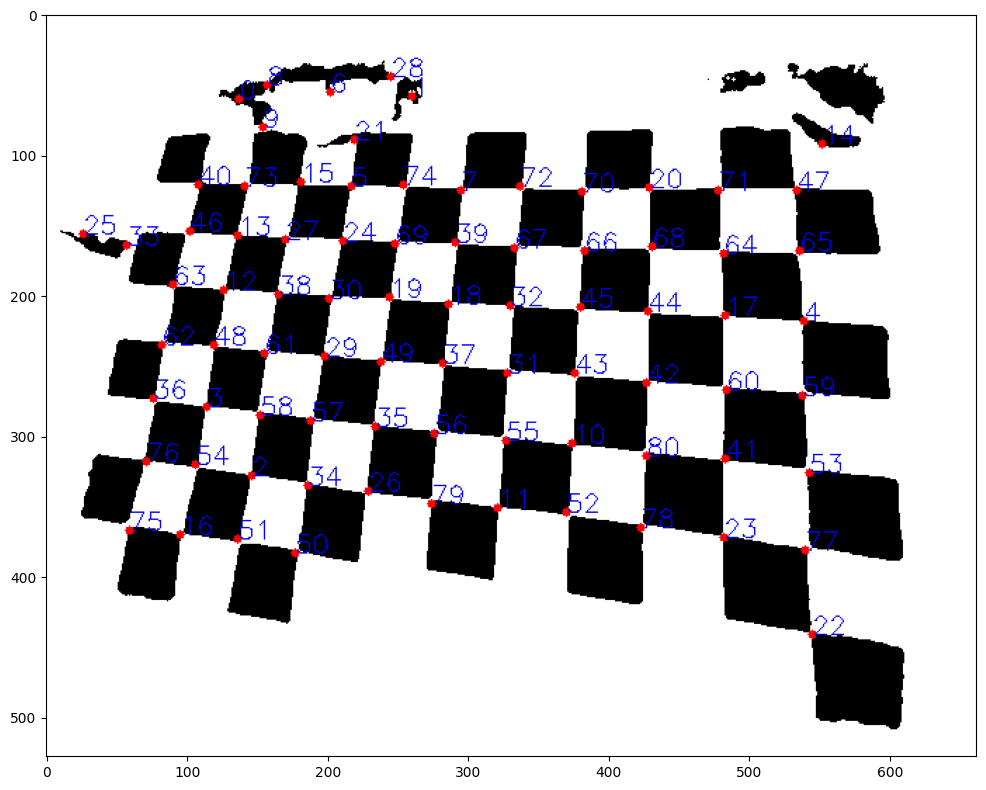

Number of points:  78


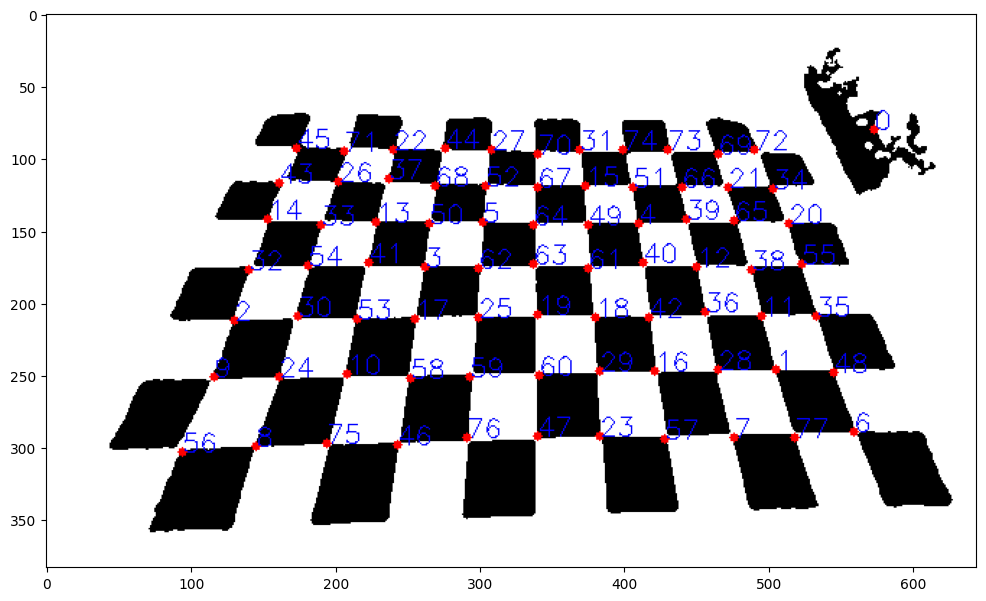

In [16]:
filter_points_in_images = []
for img in bright_images:
    filter_points_in_images.append(detect_key_points(img).tolist())

#### IV. Measure chessboard size

In [17]:
def cal_horizontal_angle_and_distance(pt1, pt2):
    horizontal_length = np.abs(pt1[1] - pt2[1])
    vertical_length = np.abs(pt1[0] - pt2[0])
    angle = np.arctan(vertical_length / (horizontal_length + 0.00000000000000000000000000000001))
    distance = np.sqrt(horizontal_length * horizontal_length + vertical_length * vertical_length)
    return angle, distance

def find_horizontal_adjacent_points(this_pt, all_pt, max_angle = np.pi / 10, radius = 65):
    left = []
    right = []
    this_pt_index = -1
    for pt in all_pt:
        if (pt[1] == this_pt[1] and pt[0] == this_pt[0]):
            this_pt_index = all_pt.index(pt)
            continue
        angle, distance = cal_horizontal_angle_and_distance(pt, this_pt)
        if (angle < max_angle and distance < radius):
            if (pt[1] < this_pt[1]):
                left.append(all_pt.index(pt))
            else:
                right.append(all_pt.index(pt))
    
    def condition(pt_index):
        angle, distance = cal_horizontal_angle_and_distance(all_pt[pt_index], this_pt)
        return distance
    
    left.sort(key=condition) 
    right.sort(key=condition) 
    
    res_left = None
    res_right = None
    if (len(left) != 0):
        res_left = left[0]
    if (len(right) != 0):
        res_right = right[0]

    return [res_left, res_right]

In [18]:
def find_line(pt_index, lines, left = False, right = False):
    if pt_index is None:
        return None
    for line in lines: 
        if line[-1] == pt_index and left == True: 
            return line
        if line[0] == pt_index and right == True: 
            return line
        
def find_adjacent_pair_points_on_a_line(pt_index, lines):
    left = None
    right = None
    for line in lines: 
        if pt_index in line:
            position_of_point_on_line = line.index(pt_index)
            if position_of_point_on_line > 0:
                left = line[position_of_point_on_line - 1]
            if position_of_point_on_line != (len(line) - 1):
                right = line[position_of_point_on_line + 1]
    return left, right

In [19]:
def construct_line_array(filter_points):
    horizontal_lines = []
    for pt_index, pt in enumerate(filter_points):
        lpt_index, rpt_index = find_adjacent_pair_points_on_a_line(pt_index, horizontal_lines)
        if lpt_index is not None and rpt_index is not None: 
            continue
        if lpt_index is not None and rpt_index is None:
            rpt_index = find_horizontal_adjacent_points(pt, all_pt)[1]
            if rpt_index != None:
                line = find_line(pt_index, horizontal_lines, left = True)
                right_line = find_line(rpt_index, horizontal_lines, right = True)
                if right_line is None:
                    line.append(rpt_index)
                else:
                    line.extend(right_line)
                    horizontal_lines.remove(right_line)    
        
        if rpt_index is not None and lpt_index is None:
            lpt_index = find_horizontal_adjacent_points(pt, all_pt)[0]
            if lpt_index != None:
                line = find_line(pt_index, horizontal_lines, right = True)
                left_line = find_line(lpt_index, horizontal_lines, left = True)
                if left_line is None:
                    line.insert(0, lpt_index)
                else:
                    left_line.extend(line)
                    horizontal_lines.remove(line)
                    
        if rpt_index is None and lpt_index is None:
            lpt_index, rpt_index = find_horizontal_adjacent_points(pt, all_pt)
            left_line = find_line(lpt_index, horizontal_lines, left = True)
            right_line = find_line(rpt_index, horizontal_lines, right = True)
            if lpt_index is not None: 
                if left_line is not None:
                    left_line.append(pt_index)
                    if rpt_index is not None:
                        if right_line is not None:
                            left_line.extend(right_line)
                            horizontal_lines.remove(right_line)
                        else:
                            left_line.append(rpt_index)
                else:
                    if rpt_index is not None:
                        if right_line is not None:
                            right_line.insert(0, pt_index)
                            right_line.insert(0, lpt_index)
                        else:
                            horizontal_lines.append([lpt_index, pt_index, rpt_index])
                    else:
                        horizontal_lines.append([lpt_index, pt_index])
            else:
                if rpt_index is not None:
                    if right_line is not None:
                        right_line.insert(0, pt_index)
                    else:
                        horizontal_lines.append([pt_index, rpt_index])
    return horizontal_lines

In [20]:
horizontal_lines_array_in_images = []
for all_pt in filter_points_in_images:
    temp  = construct_line_array(all_pt)
    horizontal_lines_array_in_images.append(temp)
    print("horizontal line", temp, "\n")

horizontal line [[22, 2, 34, 33, 72, 21, 20, 48, 32, 62, 40], [5, 76, 9, 52, 53, 54, 69, 60, 55, 19, 67], [6, 49, 36, 64, 63, 35, 18, 14, 38, 46, 39], [8, 68, 47, 78, 51, 59, 7, 45, 12, 10], [11, 43, 31, 56, 77, 70, 61, 57, 71, 13, 3], [41, 44, 27, 65, 25, 26, 15, 24, 23, 73, 42], [17, 29, 16, 58, 75, 1, 37, 66, 74, 4, 28]] 

horizontal line [[3, 60, 59, 73, 58, 57, 47, 33, 56, 21, 12], [68, 4, 29, 41, 74, 42, 15, 50, 7, 30, 6], [26, 70, 8, 16, 9, 51, 17, 43, 53, 27, 52], [72, 44, 32, 75, 19, 10, 18, 37, 45, 5, 31], [67, 65, 40, 64, 23, 22, 24, 39, 66, 36], [25, 48, 46, 20, 55, 0, 54, 11, 49, 38, 71], [35, 63, 69, 2, 62, 1, 61, 34, 14, 13, 28]] 

horizontal line [[8, 6, 1], [76, 54, 2, 34, 26, 79, 11, 52, 78, 23, 77], [36, 3, 58, 57, 35, 56, 55, 10, 80, 41, 53], [40, 73, 15, 5, 74, 7, 72, 70, 20, 71, 47], [63, 12, 38, 30, 19, 18, 32, 45, 44, 17, 4], [75, 16, 51, 50], [25, 33, 46, 13, 27, 24, 69, 39, 67, 66, 68, 64, 65], [6, 28], [62, 48, 61, 29, 49, 37, 31, 43, 42, 60, 59]] 

horizonta

In [21]:
def measure_chessboard_size(horizontal_lines_array):
    average_length = sum(len(line) for line in horizontal_lines_array) / len(horizontal_lines_array)
    filtered_lines = [line for line in horizontal_lines_array if abs(len(line) - average_length) <= 3]
    max_length = max(len(line) for line in filtered_lines)
    return [max_length + 1, len(filtered_lines) + 1]

In [22]:
for i in range (len(horizontal_lines_array_in_images)):
    chessboard_size = measure_chessboard_size(horizontal_lines_array_in_images[i])
    print('Chessboard size of image '+ str(i+1) + ': '  + str(chessboard_size[0]) + 'x'+ str(chessboard_size[1]))

Chessboard size of image 1: 12x8
Chessboard size of image 2: 12x8
Chessboard size of image 3: 12x6
Chessboard size of image 4: 12x8
